# Introduction

This notebook explores the keystroke dataset for the study titled __High-accuracy
detection of early Parkinson's Disease using multiple characteristics of finger
movement while typing__. The notebook goes through various data-cleaning
techniques to clean and consolidate the provided data files. A number of
observations and visualizations are also included.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
combined_user_df = pd.read_csv('../data/combined_user.csv', index_col=0)
combined_user_df.head()

,BirthYear,Female,Parkinsons,Tremors,DiagnosisYear,Sided_Left,Sided_None,Sided_Right,UPDRS_1,UPDRS_2,...,RS_Flight time,SL_Hold time,SL_Latency time,SL_Flight time,SR_Hold time,SR_Latency time,SR_Flight time,SS_Hold time,SS_Latency time,SS_Flight time
ARUGT4UL2R,1955.0,0,1,1,NaN,0,1,0,0,0,...,449.251515,106.166055,467.359633,345.688991,110.735714,508.466667,393.742857,59.555556,187.611111,129.555556
UUIZH9TDXR,1958.0,1,1,0,2015.0,1,0,0,0,0,...,372.521396,212.172495,648.433813,412.726685,194.990293,639.322069,403.426264,274.643426,587.838292,329.879463
JIRZDKEJQN,1985.0,0,1,1,2014.0,0,1,0,0,0,...,315.640000,97.480000,388.112381,309.984762,95.813158,517.692105,474.928947,89.070000,196.895000,140.640000
XWAX2IHF3O,1970.0,1,1,1,2007.0,1,0,0,0,0,...,199.378162,105.211369,186.407440,194.914682,81.506897,258.286362,238.354281,7932.182057,163.837912,185.707210
2X17VCRRQA,1951.0,0,1,1,2003.0,1,0,0,0,0,...,323.259524,82.000000,460.950000,375.000000,0.000000,0.000000,0.000000,230.500000,263.700000,48.800000


# Visualization

Missing data count:

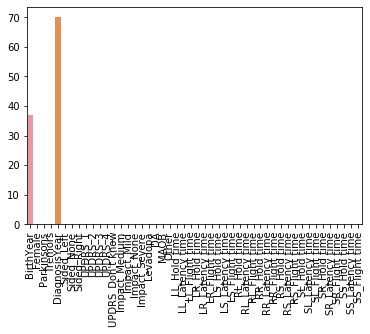

In [3]:
missing_data = combined_user_df.isnull().sum()

g = sns.barplot(missing_data.index, missing_data)
g.set_xticklabels(labels=missing_data.index, rotation=90)

plt.show()

Birth year distribution, gender count, and tremor count:

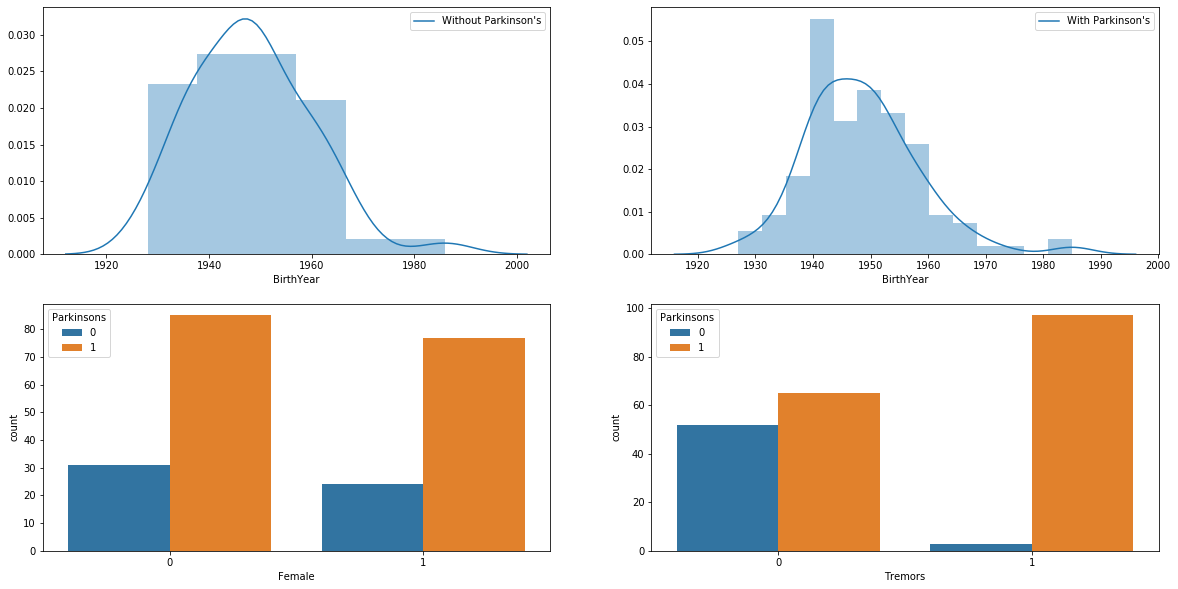

In [4]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))


sns.distplot(
    combined_user_df.loc[combined_user_df['Parkinsons'] == 0, 'BirthYear'].dropna(axis=0),
    kde_kws = {'label': "Without Parkinson's"},
    ax = ax[0][0]
)
sns.distplot(
    combined_user_df.loc[combined_user_df['Parkinsons'] == 1, 'BirthYear'].dropna(axis=0),
    kde_kws = {'label': "With Parkinson's"},
    ax = ax[0][1]
)

sns.countplot(x='Female', hue='Parkinsons', data=combined_user_df, ax=ax[1][0])
sns.countplot(x='Tremors', hue='Parkinsons', data=combined_user_df, ax=ax[1][1])

plt.show()

We will use boxplots to visualize distributions of different time data (hold
time, latency time, and flight time) between participants with and without
Parkinsons's. Each subplot will contain data in a specific typing switch
type--for example, the top left subplot contains typing data when participants
go from a left-hand key to another left-hand key (denoted as `LL` above the
subplot), while the top right one contains data when participants switch from a
left-hand key to a space (`LS`).

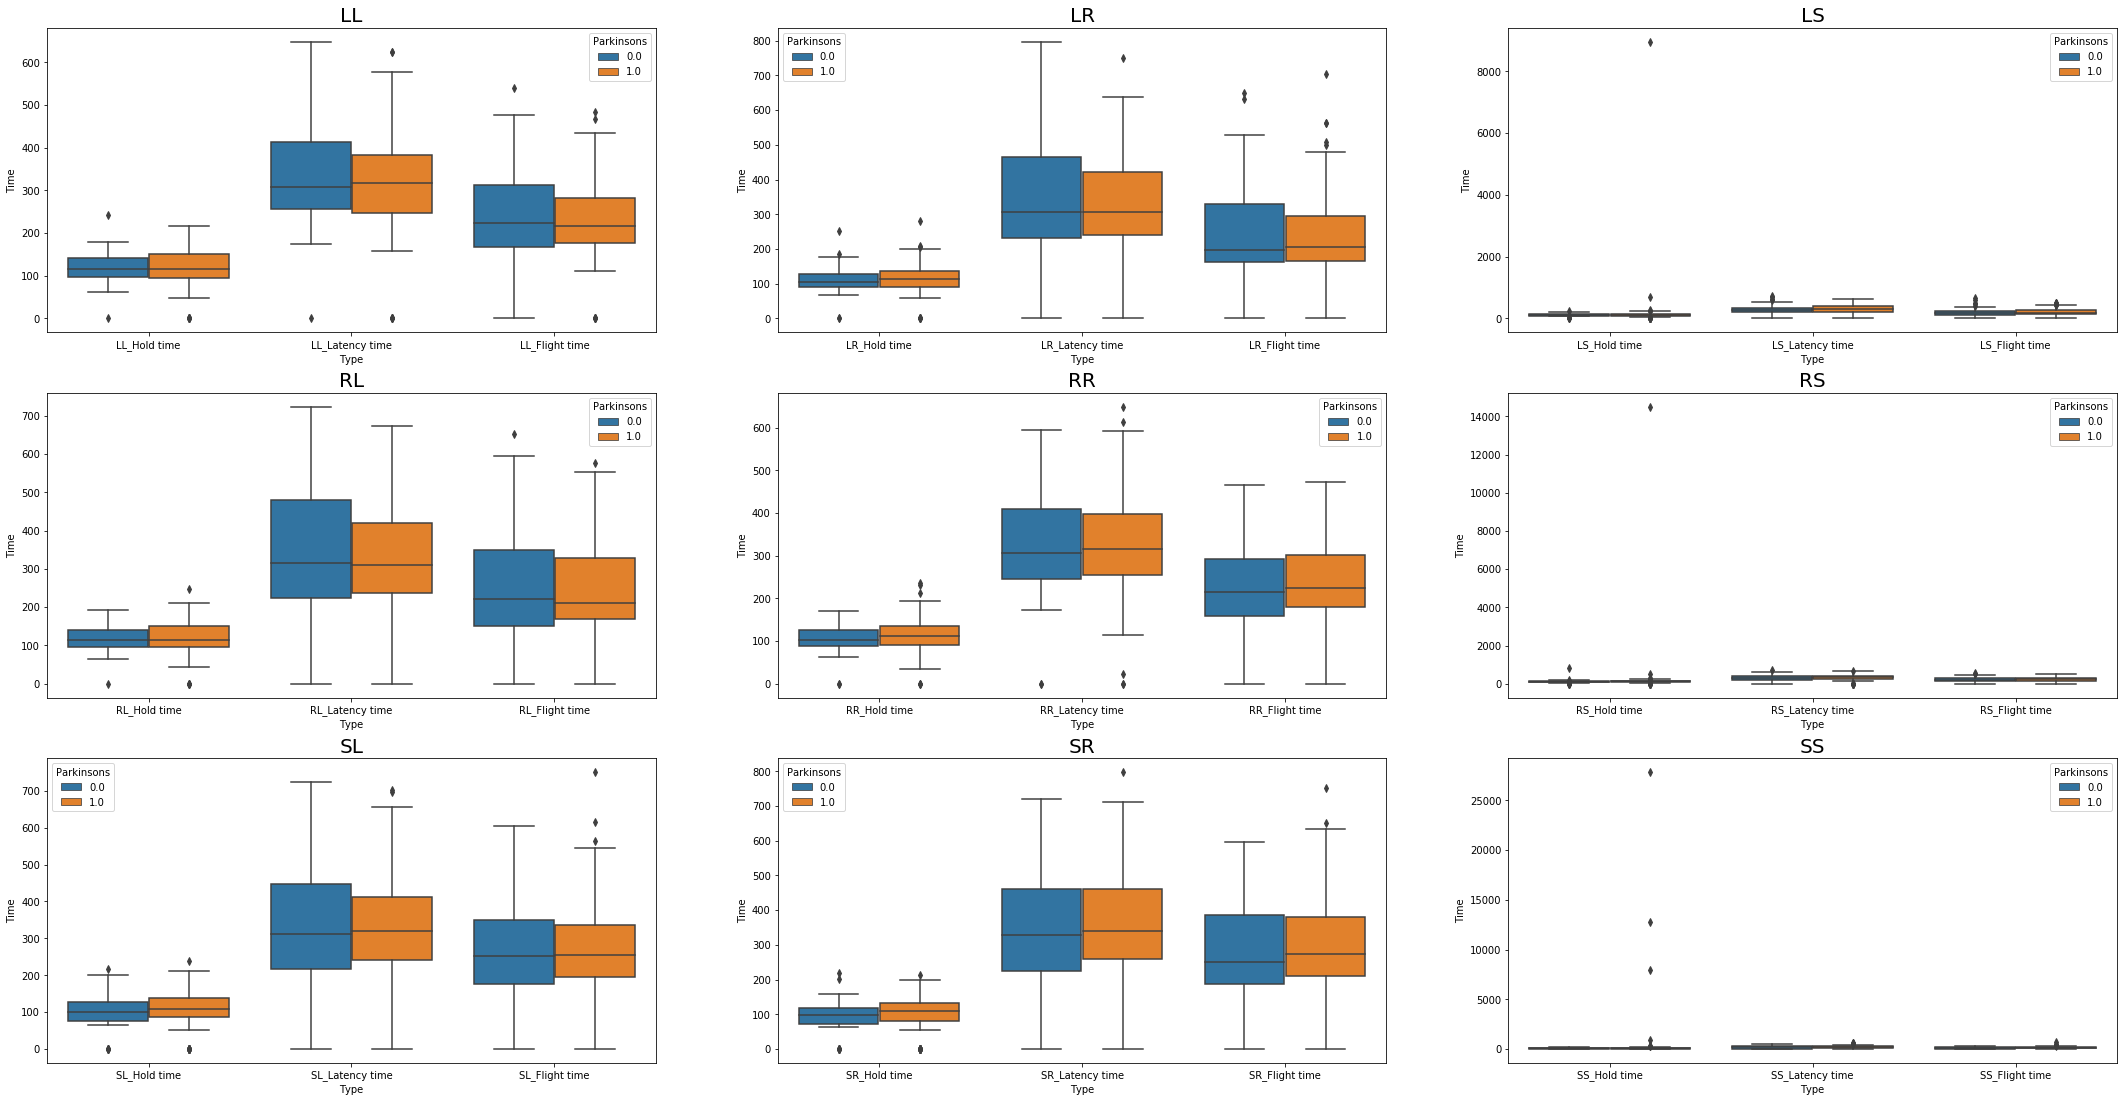

In [5]:
column_names = [first_hand + second_hand + '_' + time 
                for first_hand in ['L', 'R', 'S'] 
                for second_hand in ['L', 'R', 'S'] 
                for time in ['Hold time', 'Latency time', 'Flight time']]


f, ax = plt.subplots(3, 3, figsize=(10, 5))

plt.subplots_adjust(
    right = 3,
    top = 3
)

for i in range(9):
    temp_columns = column_names[3 * i : 3 * i + 3]
    stacked_df = combined_user_df[temp_columns].stack().reset_index()
    
    stacked_df = stacked_df.rename(
        columns={'level_0': 'index', 'level_1': 'Type', 0: 'Time'})
    stacked_df = stacked_df.set_index('index')

    for index in stacked_df.index:
        stacked_df.loc[index, 'Parkinsons'] = combined_user_df.loc[index, 'Parkinsons']
    
    sns.boxplot(x='Type', y='Time',
                hue='Parkinsons',
                data=stacked_df,
                ax=ax[i // 3][i % 3]
                ).set_title(column_names[i * 3][: 2], fontsize=20)
    
plt.show()

Correlation matrix to visualize relationships between features

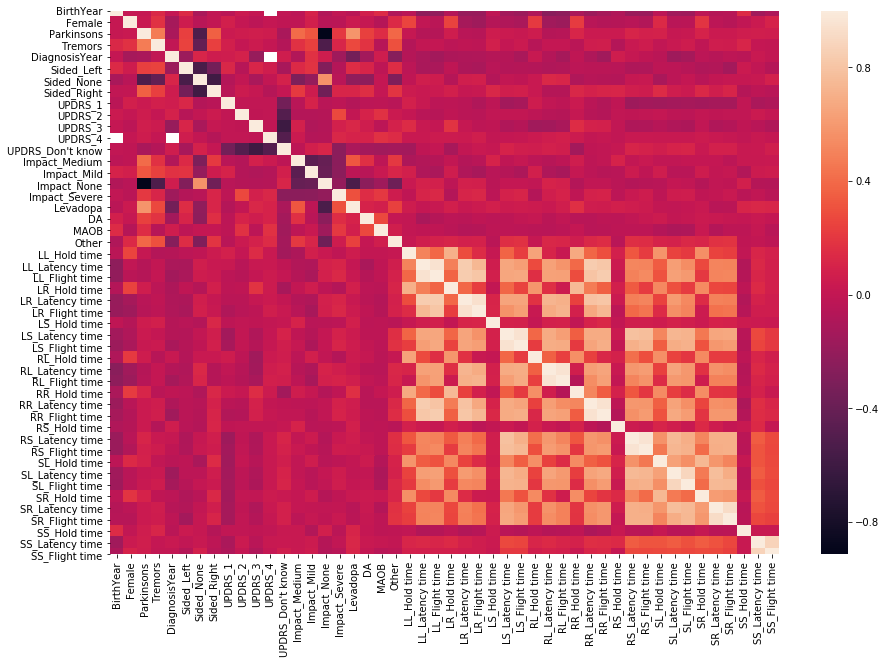

In [6]:
corr_matrix = combined_user_df.corr()

f, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(corr_matrix)

plt.show()

Fit a machine learning model to the data and obtain its feature importance

/Users/quannguyen/PycharmProjects/PyCharmBook/Chapter13/PipelineV2/venv/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


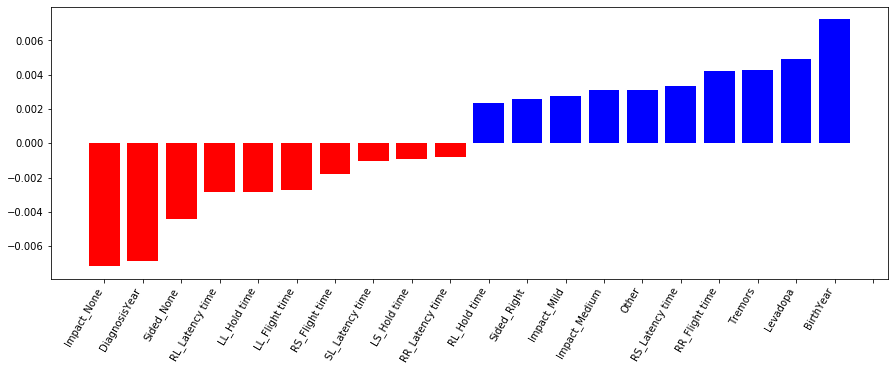

In [7]:
from sklearn.svm import LinearSVC


combined_user_df['BirthYear'].fillna(combined_user_df['BirthYear'].mode(dropna=True)[0], inplace=True)
combined_user_df['DiagnosisYear'].fillna(combined_user_df['DiagnosisYear'].mode(dropna=True)[0], inplace=True)

X_train = combined_user_df.drop(['Parkinsons'], axis=1)
y_train = combined_user_df['Parkinsons']

clf = LinearSVC()
clf.fit(X_train, y_train)


nfeatures = 10

coef = clf.coef_.ravel()
top_positive_coefs = np.argsort(coef)[-nfeatures :]
top_negative_coefs = np.argsort(coef)[: nfeatures]
top_coefs = np.hstack([top_negative_coefs, top_positive_coefs])

plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coef[top_coefs]]
plt.bar(np.arange(2 * nfeatures), coef[top_coefs], color = colors)
feature_names = np.array(X_train.columns)
plt.xticks(np.arange(0, 1 + 2 * nfeatures), feature_names[top_coefs], rotation=60, ha='right')

plt.show()
